  Cloning https://github.com/mindee/doctr.git to /tmp/pip-install-0ohuipk9/python-doctr_8f12985c074e4bbaa2ac178cfc0aba2d
  Running command git clone --filter=blob:none --quiet https://github.com/mindee/doctr.git /tmp/pip-install-0ohuipk9/python-doctr_8f12985c074e4bbaa2ac178cfc0aba2d
  Resolved https://github.com/mindee/doctr.git to commit 183cf65a520771aa13ccfdfd47e68dbcf2da541f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Saving image1.jpg to image1 (1).jpg


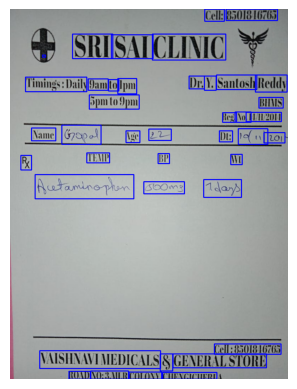

In [2]:
# Uninstall the preinstalled tensorflow version if we want to work with PyTorch as backend
!pip uninstall -y tensorflow
# Install doctr
!pip install python-doctr[torch,viz]@git+https://github.com/mindee/doctr.git

# Imports
import os
import tempfile
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
from doctr.models import detection_predictor, recognition_predictor, page_orientation_predictor, crop_orientation_predictor
from doctr.io import DocumentFile
from doctr.utils.geometry import detach_scores

# Helper function to convert relative coordinates to absolute pixel values
def _to_absolute(geom, img_shape: tuple[int, int]) -> list[list[int]]:
    h, w = img_shape
    if len(geom) == 2:  # Assume straight pages = True -> [[xmin, ymin], [xmax, ymax]]
        (xmin, ymin), (xmax, ymax) = geom
        xmin, xmax = int(round(w * xmin)), int(round(w * xmax))
        ymin, ymax = int(round(h * ymin)), int(round(h * ymax))
        return [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
    else:  # For polygons, convert each point to absolute coordinates
        return [[int(point[0] * w), int(point[1] * h)] for point in geom]

# Upload an image from the local directory
uploaded_files = files.upload()

# Assuming you uploaded one image, get its filename
uploaded_filename = list(uploaded_files.keys())[0]

# Read the uploaded image
receipt_image = cv2.imdecode(np.frombuffer(uploaded_files[uploaded_filename], np.uint8), cv2.IMREAD_COLOR)

# Save the uploaded image to a temporary file
with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
    temp_filename = temp_file.name
    cv2.imwrite(temp_filename, receipt_image)

# Create a folder named after the image file (without the extension)
base_filename = os.path.splitext(uploaded_filename)[0]
output_folder = base_filename  # you can change this as needed
os.makedirs(output_folder, exist_ok=True)

# Define the detection predictor
det_predictor = detection_predictor(
    arch="db_resnet50",
    pretrained=True,
    assume_straight_pages=True,
    symmetric_pad=True,
    preserve_aspect_ratio=True,
    batch_size=1,
)  # .cuda().half()  # Uncomment this line if you have a GPU

# Define the postprocessing parameters (optional)
det_predictor.model.postprocessor.bin_thresh = 0.3
det_predictor.model.postprocessor.box_thresh = 0.1

# Load the document image from the temporary file
docs = DocumentFile.from_images([temp_filename])
results = det_predictor(docs)

# Initialize a counter for naming cropped word images
word_index = 0

# Loop over each document and its detection results
for doc, res in zip(docs, results):
    img_shape = (doc.shape[0], doc.shape[1])
    # Detach the probability scores from the results
    detached_coords, prob_scores = detach_scores([res.get("words")])

    for coords in detached_coords[0]:
        # If the coordinates are given as a flat array of 4 numbers, reshape them to 2 points
        coords = coords.reshape(2, 2).tolist() if coords.shape == (4,) else coords.tolist()

        # Convert relative to absolute pixel coordinates
        points = np.array(_to_absolute(coords, img_shape), dtype=np.int32).reshape((-1, 1, 2))

        # Draw the bounding box on the image (optional, for visualization)
        cv2.polylines(receipt_image, [points], isClosed=True, color=(255, 0, 0), thickness=2)

        # Compute an axis-aligned bounding rectangle for the detected word
        x, y, w, h = cv2.boundingRect(points)

        # Crop the word region from the image
        cropped_word = receipt_image[y:y+h, x:x+w]

        # Build the path to save the cropped word image
        save_path = os.path.join(output_folder, f'word_{word_index}.png')

        # Save the cropped image
        cv2.imwrite(save_path, cropped_word)

        word_index += 1

# Display the image with bounding boxes (for visualization)
%matplotlib inline
plt.imshow(cv2.cvtColor(receipt_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [3]:
!pip install gdown
!pip install --upgrade datasets
!pip install tokenizers
!pip install transformers==4.46.1
!pip install torch==2.5.1
!pip install jiwer
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 63.9 MB/s eta 0:00:00
  

In [5]:
!gdown https://drive.google.com/uc?id=1jfYUY_cxyAYaiaNAhWhNnDYtvQdxG5Rj

Downloading...
From (original): https://drive.google.com/uc?id=1jfYUY_cxyAYaiaNAhWhNnDYtvQdxG5Rj
From (redirected): https://drive.google.com/uc?id=1jfYUY_cxyAYaiaNAhWhNnDYtvQdxG5Rj&confirm=t&uuid=262a0f1a-c3dd-4d54-a5f1-938170c98187
To: /content/Dataset.zip
100% 39.2M/39.2M [00:00<00:00, 82.6MB/s]


In [6]:
!unzip /content/Dataset.zip

Archive:  /content/Dataset.zip
   creating: Combination of Siddarth and venkat/
  inflating: Combination of Siddarth and venkat/app.py  
   creating: Combination of Siddarth and venkat/eval/
  inflating: Combination of Siddarth and venkat/eval/127.jpg  
  inflating: Combination of Siddarth and venkat/eval/128.jpg  
  inflating: Combination of Siddarth and venkat/eval/129.jpg  
  inflating: Combination of Siddarth and venkat/eval/130.jpg  
  inflating: Combination of Siddarth and venkat/eval/131.jpg  
  inflating: Combination of Siddarth and venkat/eval/132.jpg  
  inflating: Combination of Siddarth and venkat/eval/133.jpg  
  inflating: Combination of Siddarth and venkat/eval/134.jpg  
  inflating: Combination of Siddarth and venkat/eval/135.jpg  
  inflating: Combination of Siddarth and venkat/eval/136.jpg  
  inflating: Combination of Siddarth and venkat/eval/137.jpg  
  inflating: Combination of Siddarth and venkat/eval/138.jpg  
  inflating: Combination of Siddarth and venkat/eval/

In [8]:
import pandas as pd

df = pd.read_csv('/content/Combination of Siddarth and venkat/metadata_fixed.txt',
                 sep='\t',  # Specify tab as the delimiter
                 header=None,  # No header in the file
                 names=["file_name", "text"])  # Set column names

# Fix file names that end with "jp" instead of "jpg"
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)

# Display the first few rows to verify
print(df.head())
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='/content/Combination of Siddarth and venkat/train/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/Combination of Siddarth and venkat/train/',
                           df=test_df,
                           processor=processor)

# Print dataset sizes
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

# Check encoding for the first training example
encoding = train_dataset[0]
for k, v in encoding.items():
    print(k, v.shape)


  file_name                                 text
0     1.jpg  Augmentin DDS Suspension 5ml 2times
1     2.jpg                Almox 500mg Tab1 8hrs
2     3.jpg   Ascoril LS Junior Syrup 5ml 2times
3     4.jpg            Aptimust Syrup 5ml 2times
4     5.jpg                Alfoo 10mg Tab1 daily
Number of training examples: 205
Number of validation examples: 52
pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [9]:
import os
# Get the file name and construct the full path
file_name = train_df['file_name'][0]
file_path = os.path.join(train_dataset.root_dir, file_name)

# Print the full path for debugging
print(f"Attempting to open: {file_path}")

# Check if the file exists before opening
if os.path.exists(file_path):
    image = Image.open(file_path).convert("RGB")
else:
    print(f"File not found: {file_path}")


Attempting to open: /content/Combination of Siddarth and venkat/train/145.jpg


In [10]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Ala-Tet 250mg 6hrs


In [11]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [13]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    num_train_epochs=4
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
from evaluate import load

# Load the CER metric from Hugging Face datasets
cer_metric = load("cer")

In [15]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [16]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

<ipython-input-16-21dc7b56330e>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 245121733088 (245121733088-mvsr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=104, training_loss=1.4360347791359975, metrics={'train_runtime': 127.5949, 'train_samples_per_second': 6.427, 'train_steps_per_second': 0.815, 'total_flos': 7.256142695419085e+17, 'train_loss': 1.4360347791359975, 'epoch': 4.0})

In [17]:
import os
import torch
from PIL import Image

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict the text for a single image
def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)  # Move to the same device as the model

    # Perform inference
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decode the generated ids to text
    predicted_text = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return predicted_text


In [18]:
def predict_and_save_results(image_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all files in the image folder
    for image_file in os.listdir(image_folder):
        if image_file.endswith(".jpg") or image_file.endswith(".png"):  # Handle image formats
            image_path = os.path.join(image_folder, image_file)

            # Predict text for the image
            predicted_text = predict_image(image_path)

            # Create the output .txt file path
            txt_file_name = os.path.splitext(image_file)[0] + ".txt"  # Same name as image but with .txt extension
            txt_file_path = os.path.join(output_folder, txt_file_name)

            # Save the predicted text to the file
            with open(txt_file_path, 'w') as f:
                f.write(predicted_text)

            print(f"Saved predicted text for {image_file} to {txt_file_path}")

# Specify the input folder containing images and the output folder for text files
image_folder = '/content/image1 (1)'  # Folder containing the images
output_folder = '/content/doctor/'  # Folder to save the predicted text files
# Predict and save results for all images in the folder
predict_and_save_results(image_folder, output_folder)

print("All predictions saved.")


Saved predicted text for word_22.png to /content/doctor/word_22.txt
Saved predicted text for word_9.png to /content/doctor/word_9.txt
Saved predicted text for word_40.png to /content/doctor/word_40.txt
Saved predicted text for word_33.png to /content/doctor/word_33.txt
Saved predicted text for word_4.png to /content/doctor/word_4.txt
Saved predicted text for word_31.png to /content/doctor/word_31.txt
Saved predicted text for word_30.png to /content/doctor/word_30.txt
Saved predicted text for word_35.png to /content/doctor/word_35.txt
Saved predicted text for word_32.png to /content/doctor/word_32.txt
Saved predicted text for word_14.png to /content/doctor/word_14.txt
Saved predicted text for word_28.png to /content/doctor/word_28.txt
Saved predicted text for word_37.png to /content/doctor/word_37.txt
Saved predicted text for word_15.png to /content/doctor/word_15.txt
Saved predicted text for word_6.png to /content/doctor/word_6.txt
Saved predicted text for word_11.png to /content/docto

In [ ]:
!zip -r /content/predicted_texts.zip /content/doctor